# Worksheet 2 - Asymptotic Regulation of Two Heated Tanks

In this notebook I'll deal with H2.2 - Another Notebook will be used for H2.3

Tasks:
- Implement a MIMO P-controller focusing on mode 1 only
- Synthesize an LQR law as an alternative to the P law

In [ ]:
import numpy as np
import control as cp
import matplotlib.pyplot as plt
from control.matlab import *
from scipy.linalg import solve_continuous_are

## System Model (From TP1)

$x = [T_1, T_2]^T$ (temperatures of tank 1 and tank 2)
$u = [u_1, u_2]^T$ (heater power for each tank)

**Mode 1** (ON1 ∧ OFF2):

$$\dot{x} = Ax + Bu$$
$$y = Cx + Du$$

In [ ]:
ks = 0.065  # Thermostat gain

a1 = 0.01   # Heat loss coefficient tank 1
a2 = 0.01   # Heat loss coefficient tank 2
b1 = 0.005  # Coupling coefficient 1→2
b2 = 0.005  # Coupling coefficient 2→1
h1 = 2      # Heater gain tank 1
h2 = 2      # Heater gain tank 2

# State-space matrices for mode 1 (ON1 ∧ OFF2)
A = np.array([[-a1, b1],
              [b2, -a2]])

B = np.array([[h1, 0],
              [0,  h2]])

C = np.eye(2)
D = np.array([[0, 0],
              [0, 0]])

HeatedTanks = ss(A, B, C, D)

print("A: ")
print(A)
print("\nB:")
print(B)
print("\nopen-loop poles:")
print(np.linalg.eigvals(A))

A: 
[[-0.01   0.005]
 [ 0.005 -0.01 ]]

B:
[[2 0]
 [0 2]]

open-loop poles:
[-0.005 -0.015]


## MIMO P-Controller

$$u = K_p e = K_p (r - y)$$
$$K_p = \begin{bmatrix} k_{p1} & 0 \\ 0 & k_{p2} \end{bmatrix}$$

In [ ]:
kp1 = 1.0
kp2 = 1.0

Kp_diag = np.array([[kp1, 0],
                     [0, kp2]])

print("Diagonal P-controller gain matrix:")
print(Kp_diag)

C_p_diag_ss = ss([], [], [], Kp_diag)

C_p1 = tf([kp1], [1])  # Controller for tank 1
C_p2 = tf([kp2], [1])  # Controller for tank 2

Diagonal P-controller gain matrix:
[[1. 0.]
 [0. 1.]]


[-2.005+0.j -2.015+0.j]


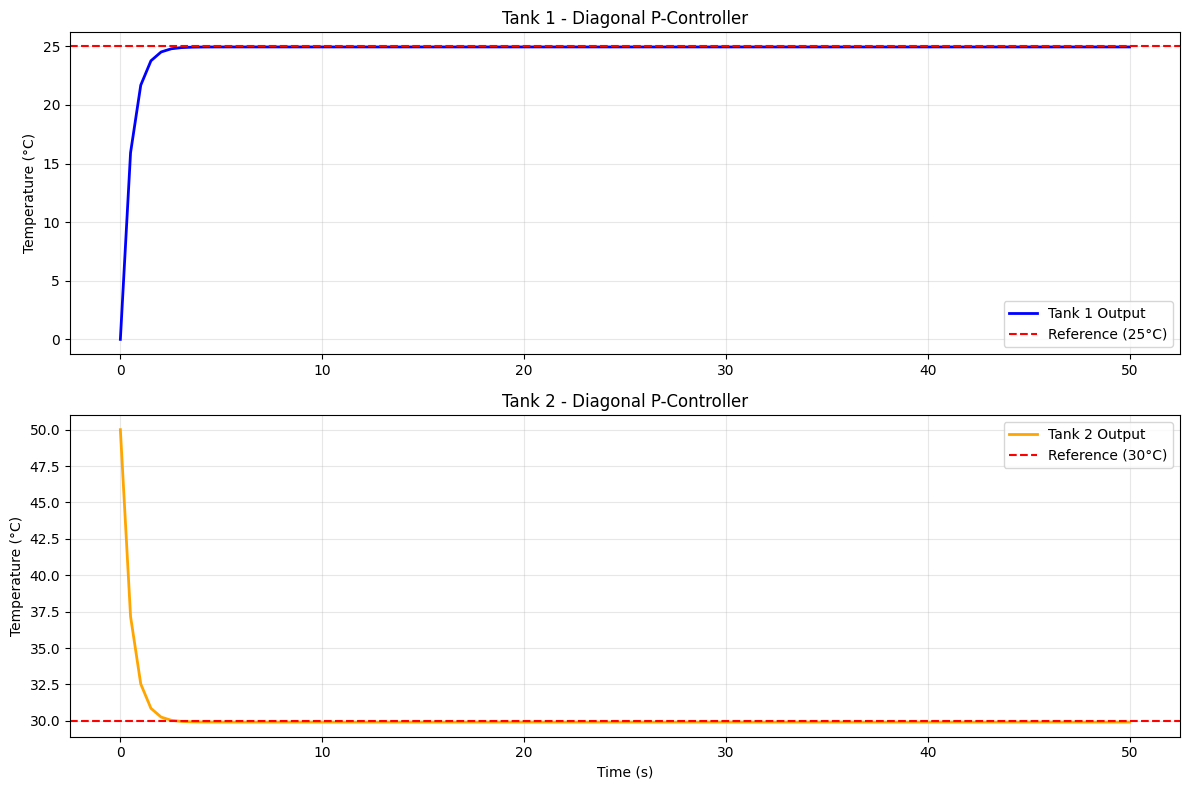


Steady-state error Tank 1: 0.050 °C
Steady-state error Tank 2: 0.087 °C


In [ ]:
C_p_diag_tf = append(C_p1, C_p2)
T_p_diag = feedback(series(C_p_diag_ss, HeatedTanks), np.eye(2))

print(T_p_diag.poles())

# Step response
t0, tfin = 0,50
t = np.linspace(t0, tfin, 100)

r1 = 25 * np.ones(len(t))
r2 = 30 * np.ones(len(t))
r = np.column_stack([r1, r2])

x0 = np.array([0, 50])

y_p_diag, t_out, x_out = lsim(T_p_diag, r, t, X0=x0)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Tank 1
axes[0].plot(t_out, y_p_diag[:, 0], 'b-', linewidth=2, label='Tank 1 Output')
axes[0].axhline(y=25, color='red', linestyle='--', label='Reference (25°C)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Tank 1 - Diagonal P-Controller')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Tank 2
axes[1].plot(t_out, y_p_diag[:, 1], 'orange', linewidth=2, label='Tank 2 Output')
axes[1].axhline(y=30, color='red', linestyle='--', label='Reference (30°C)')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Tank 2 - Diagonal P-Controller')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ss_error_1 = 25 - y_p_diag[-1, 0]
ss_error_2 = 30 - y_p_diag[-1, 1]
print(f"\nSteady-state error Tank 1: {ss_error_1:.3f} °C")
print(f"Steady-state error Tank 2: {ss_error_2:.3f} °C")

## LQR Controller

$$J = \int_0^\infty (x^T Q x + u^T R u) dt$$

In [ ]:
# LQR Design

Q = np.diag([10.0, 10.0])
R = np.diag([1.0, 1.0])

K_lqr, S, E = cp.lqr(HeatedTanks, Q, R)

print("\nLQR gain matrix K:")
print(K_lqr)
print("\nClosed-loop eigenvalues (with LQR):")
print(E)


LQR gain matrix K:
[[3.15728260e+00 2.49604716e-03]
 [2.49604716e-03 3.15728260e+00]]

Closed-loop eigenvalues (with LQR):
[-6.3245573  -6.32457311]


### LQR Implementation
- $u = -K(x - x_{ref}) + u_{ss}$


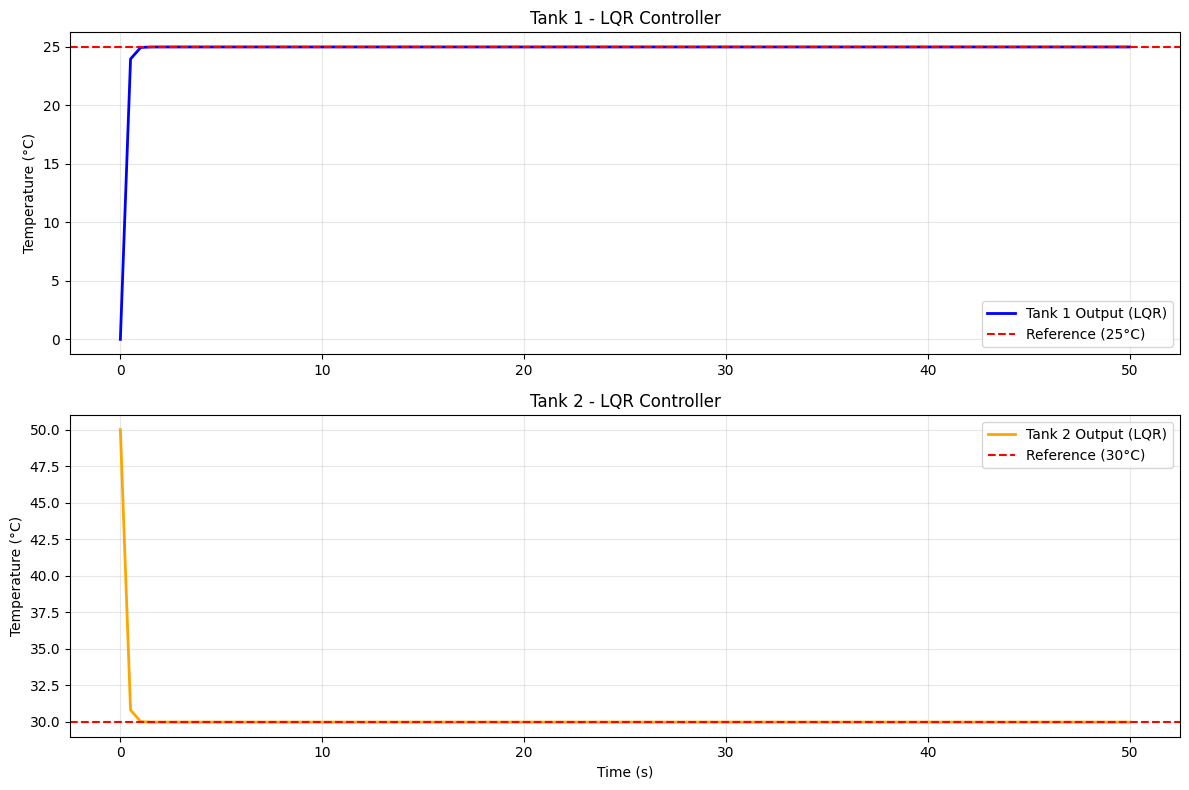


Steady-state error Tank 1: 0.016 °C
Steady-state error Tank 2: 0.028 °C


In [ ]:
x_ref = np.array([25, 30])  # target

# Create closed-loop system: dx/dt = (A - BK)x + BK*xref
A_cl = A - B @ K_lqr
B_cl = B @ K_lqr
C_cl = C
D_cl = D

T_lqr = ss(A_cl, B_cl, C_cl, D_cl)

x_ref_signal = np.tile(x_ref, (len(t), 1))
y_lqr, t_out, x_lqr = lsim(T_lqr, x_ref_signal, t, X0=x0)

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Tank 1
axes[0].plot(t_out, y_lqr[:, 0], 'b-', linewidth=2, label='Tank 1 Output (LQR)')
axes[0].axhline(y=25, color='red', linestyle='--', label='Reference (25°C)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Tank 1 - LQR Controller')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Tank 2
axes[1].plot(t_out, y_lqr[:, 1], 'orange', linewidth=2, label='Tank 2 Output (LQR)')
axes[1].axhline(y=30, color='red', linestyle='--', label='Reference (30°C)')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Tank 2 - LQR Controller')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ss_error_1_lqr = 25 - y_lqr[-1, 0]
ss_error_2_lqr = 30 - y_lqr[-1, 1]
print(f"\nSteady-state error Tank 1: {ss_error_1_lqr:.3f} °C")
print(f"Steady-state error Tank 2: {ss_error_2_lqr:.3f} °C")

## Comparison: P-Controller vs LQR

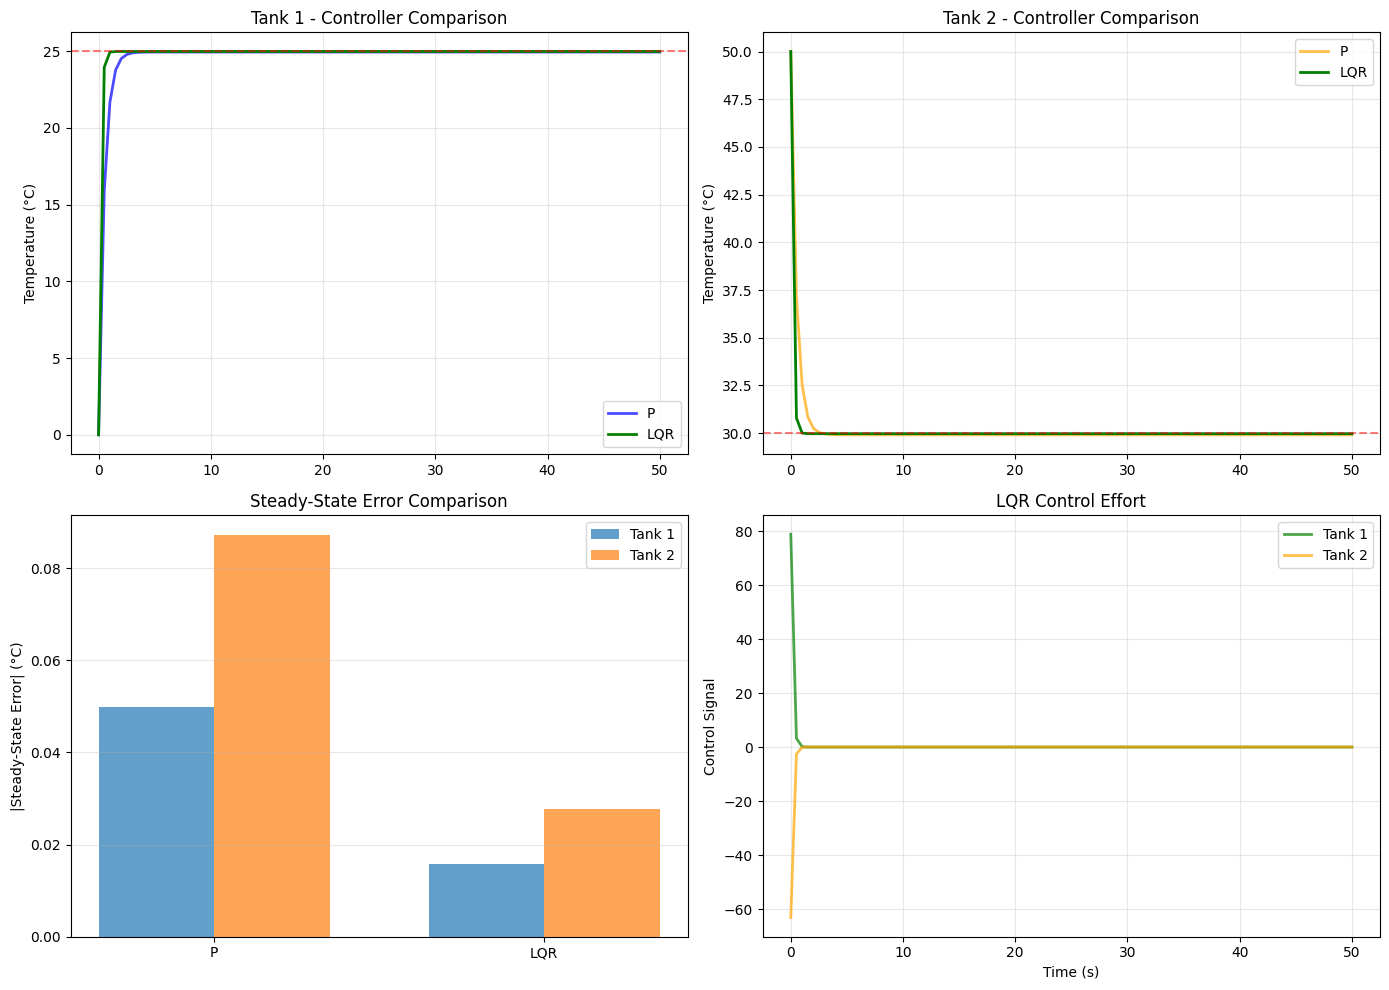

In [ ]:
# Comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Tank 1 comparison
axes[0, 0].plot(t_out, y_p_diag[:, 0], 'b-', linewidth=2, label='P', alpha=0.7)
axes[0, 0].plot(t_out, y_lqr[:, 0], 'g-', linewidth=2, label='LQR')
axes[0, 0].axhline(y=25, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Tank 1 - Controller Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Tank 2 comparison
axes[0, 1].plot(t_out, y_p_diag[:, 1], 'orange', linewidth=2, label='P', alpha=0.7)
axes[0, 1].plot(t_out, y_lqr[:, 1], 'g-', linewidth=2, label='LQR')
axes[0, 1].axhline(y=30, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_title('Tank 2 - Controller Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Steady-state errors
controllers = ['P', 'LQR']
ss_errors_1 = [abs(ss_error_1), abs(ss_error_1_lqr)]
ss_errors_2 = [abs(ss_error_2), abs(ss_error_2_lqr)]

x_pos = np.arange(len(controllers))
width = 0.35

axes[1, 0].bar(x_pos - width/2, ss_errors_1, width, label='Tank 1', alpha=0.7)
axes[1, 0].bar(x_pos + width/2, ss_errors_2, width, label='Tank 2', alpha=0.7)
axes[1, 0].set_ylabel('|Steady-State Error| (°C)')
axes[1, 0].set_title('Steady-State Error Comparison')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(controllers)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

u_lqr = -K_lqr @ (x_lqr - x_ref_signal).T

axes[1, 1].plot(t_out, u_lqr[0, :], 'g-', linewidth=2, label='Tank 1', alpha=0.7)
axes[1, 1].plot(t_out, u_lqr[1, :], 'orange', linewidth=2, label='Tank 2', alpha=0.7)
axes[1, 1].set_ylabel('Control Signal')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_title('LQR Control Effort')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()